
# K-nearest neighbor (K-NN)

First, I implement the simple K-NN algorithm then I modify it for applying on graphs.

In [169]:
import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd
import numpy as np
import networkx as nx

In [170]:
def graph_general_info(G):
    
    # some general information about the first heartbeat visibility graph
    print(nx.info(G))       
    # number of connected components
    print("\nNumber of connected components = ", nx.number_connected_components(G))
    return

Name: 
Type: Graph
Number of nodes: 284
Number of edges: 2957
Average degree:  20.8239

Number of connected components =  1


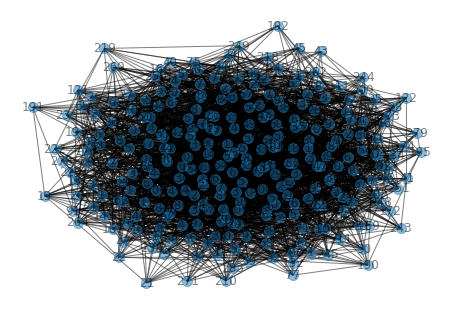

In [171]:
# K_5 = nx.complete_graph(5)
# K_3_5 = nx.complete_bipartite_graph(3, 5)
# barbell = nx.barbell_graph(10, 10)
# lollipop = nx.lollipop_graph(10, 20)

# er = nx.erdos_renyi_graph(n=284, p=0.075, seed=0)
f_rand = nx.fast_gnp_random_graph(n=284, p=0.075, seed=0)

GraphName = f_rand
nx.draw(GraphName, with_labels=True, node_size=100, alpha=.5)
graph_general_info(GraphName)
plt.draw()  # pyplot draw()

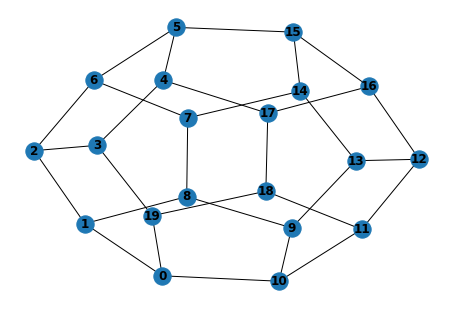

In [156]:
nx.draw(G, with_labels=True, font_weight='bold')

In [100]:
# calculate the Euclidean distance between two rows
def euclidean_distance(row1, row2):
    
    distance = 0.0
    for column_index in range(len(row1)-1):
        type_of_feature = FEATURE_TYPES[column_index]
        
        # feature(column) is continuous
        if type_of_feature == "continuous":
            distance += (row1[column_index] - row2[column_index])**2
        # feature(column) is categorical   
        else:
            if (row1[column_index] == row2[column_index]):
                distance += 0
            else:
                distance += 1
    return sqrt(distance)

## Find the closest neighbors

Using euclidean distance, we want to find the **k** nearest neighbors.

Parameters:
1. train_set: Set of training data which we want to find the **k** closest ones to the single data **test_row**
2. test_row: Single data entry that we are looking for the closest neighbor for it.
3. k: this parameter specify how many closest point we have to select.

In [101]:
# Locate the most similar neighbors
def get_neighbors(train_set, test_row, k):
    distances = list()
    for train_index, train_row in train_set.iterrows():
        dist = euclidean_distance(train_row, test_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(k):
        neighbors.append(distances[i][0])
    return neighbors

## Predict the class of the data

Using the **get_neighbors** function, we predict the class for a single data point **test_row** considering the hyper parameter **k**. In case the parameter **k** is not 1, we consider the predicted class the one which happend more.

In [102]:
def predict_classification(train_set, test_row, k):
    neighbors = get_neighbors(train_set, test_row, k)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

## K-NN algorithm

Parameters: 
1. train_set: training data point which we want to use them for predicting the class of the test points considering the closeness of the test point to this points.
2. test_set: a set of test points which we want to predict their class.
3. k: a hyper paramter of the algorithm which specifies how many nearest neighbors should have been considered for predicting the class of a test data point.

In [103]:
def knn_algo(train_set, test_set, k):
    predictions = list()
    for test_index, test_row in test_set.iterrows():
        output = predict_classification(train_set, test_row, k)
        predictions.append(output)
    return(predictions)

## Caclulate the error

Compute the error considering the true class (**actual**) and our prediction (**predicted**)

Parameters:
1. actual: an array of true classes
2. predicted: an array of predicted classes

Return:

- Error percentage.

In [104]:
# Calculate error percentage
def calculate_error(actual, predicted):
    error = 0
    for i in range(len(actual)):
        if(actual[i] != predicted[i]):
            error += 1
#     print("Here is the number of errors", error)
    return error / float(len(actual)) * 100.0

## K-NN algorithm evaluation

Evaluate K-NN algorithm and compute train and test error.

## تابع ارزیابی الگوریتم KNN

در این تابع با استفاده از توابع کمکی به صورت زیر عمل میکنیم.

1. ابتدا داده ها را با ۵ دسته تقسیم می کنیم. با استفاده از تابع split_test_train
2. برای پنج بار عملیات زیر را انجام میدهیم.
3. هر مرتبه یکی از دسته ها را به عنوان دسته تست در نظر گرفته و ۴ دسته دیگر را به عنوان دسته train در نظر میگیریم.
4. با توجه به داده های موجود در دسته تست و train و استفاده از الگوریتم knn_algo وضعیت غده تیروئید را برای داده های تست پیش بینی می کنیم.
5. خطای دسته بندی را محاسبه میکنیم.
6. در پایان لیستی با پنج عنصر را بازگشت میدهیم که خطای هر دسته ی تست را نشان میدهد.

In [105]:
# Evaluate KNN algorithm and compute errors
def evaluate_knn_algorithm(normalized_df, k):
    all_splits_df = split_test_train(normalized_df)
    
    test_errors = list()
    train_errors = list()
    for section_id, split_df in enumerate(all_splits_df):
        all_sections = pd.concat(all_splits_df)
        
        # create the train_set by dropping the test part from all the parts
        train_set = all_sections.drop(split_df.index[:]).copy()

        # create the test_set
        test_set = split_df.copy()

        # Set the values of the "Class" column of the test_set to "None" to fill it with predicted values.
        test_set.loc[:,'Class'] = None

        # Store the actual values of the Class of the thyroid for test_set into a list
        actual_test = split_df["Class"].tolist()
        
        # Store the actual values of the Class of the thyroid for train_set into a list
        actual_train = train_set["Class"].tolist()
        
        predicted_test = knn_algo(train_set, test_set, k)
        test_error = calculate_error(actual_test, predicted_test)
        test_errors.append(test_error)
        
        predicted_train = knn_algo(train_set, train_set, k)
        train_error = calculate_error(actual_train, predicted_train)
        train_errors.append(train_error)
        
        
    return test_errors, train_errors

 ##  نمودار تغییرات خطا با توجه به تغییرات مقدار K
 محاسبه ی خطای میانگین برای پنج دسته تست برای مقادیر مختلف k

In [106]:
global FEATURE_TYPES
FEATURE_TYPES = determine_type_of_feature(df)

k_list = [1, 10, 20, 50, 100, 200, 500, 800]
test_error_changes = list()
train_error_changes = list()
for k in k_list:
    (test_errors, train_errors) = evaluate_knn_algorithm(normalized_df, k)
    print("For k = ", k, "Test errors are = ", test_errors)
    
    test_mean_error = (sum(test_errors)/float(len(test_errors)))
    print('Test Mean Error: %.3f%%' % test_mean_error)
    
    print("For k = ", k, "Train errors are = ", train_errors)
    
    train_mean_error = (sum(train_errors)/float(len(train_errors)))
    print('Train Mean Error: %.3f%%' % train_mean_error)
    
    test_error_changes.append(test_mean_error)
    train_error_changes.append(train_mean_error)
    
    


KeyboardInterrupt: 

# رسم نمودار K برای KNN

در قسمت پایانی برای الگوریتم KNN مقادیر مختلف K و خطای میانگین برای پنج دسته را به ازای هر مقدار K در نمودار به شیوه ی مناسب نمایش میدهیم.

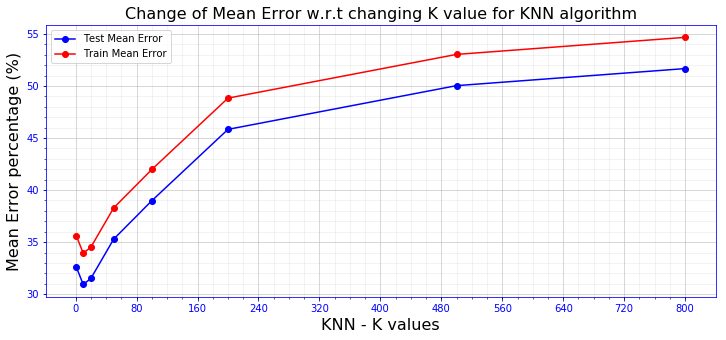

In [121]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# train_error_changes = error_changes+np.ones(8)*3
# test_error_changes = error_changes

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
ax.plot(k_list, test_error_changes,'bo-', label='Test Mean Error')
ax.plot( k_list, train_error_changes, 'ro-', label='Train Mean Error')


ax.set_xlabel('KNN - K values', fontsize=16)
ax.set_ylabel('Mean Error percentage (%)', fontsize=16)
ax.set_title('Change of Mean Error w.r.t changing K value for KNN algorithm', fontsize=16)
# ax.grid()

# Set the borders to a given color...
ax.tick_params(color='blue', labelcolor='blue')
for spine in ax.spines.values():
    spine.set_edgecolor('blue')

    
# Major ticks every 20, minor ticks every 5
major_ticks_x = np.arange(0, 801, 80)
minor_ticks_x = np.arange(0, 801, 20)

major_ticks_y = np.arange(30, 56, 5)
minor_ticks_y = np.arange(30, 56, 1)


ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)  
    
ax.legend()
fig.savefig("test.png")
plt.show()